# Árvores de Decisão

### Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import interact, FloatLogSlider, FloatSlider

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.linear_model import LogisticRegression

In [36]:
def plot_data(X, y, model=None, **kwargs):
    if y.dtype.kind == 'f':
        return plot_data_reg(X, y, model, **kwargs)
    else:
        return plot_data_clf(X, y, model, **kwargs)        

def gen_data_reg(n_samples, random_state):
    rng = np.random.RandomState(random_state)
    x = rng.uniform(2, 12, size=n_samples)
    y = 70 + 8*x + 10*rng.standard_normal(size=n_samples)
    X = x.reshape(-1, 1)
    return X, y

def plot_data_reg(X, y, model=None, N=1000):
    plt.plot(X, y, 'b.', label='data');
    plt.xlabel('x')
    plt.ylabel('y')
    if model is not None:
        plt.plot(X, model.predict(X), 'r.')
        x = np.linspace(X.min(), X.max(), N)
        plt.plot(x, model.predict(x.reshape(-1, 1)), 'r-', label=type(model).__name__)
    plt.legend()
    plt.grid()
    return

def gen_data_clf(n_samples=20, n_classes=2, overlap=0, x_scale=[0,1], random_state=None):
    '''Generate 1-D classification dataset'''
    assert overlap <= 1
    rng = np.random.RandomState(random_state)
    X = np.zeros((n_samples, 1))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        k = i % n_classes
        X[i, 0] = (k*(1-overlap) + rng.uniform())/((n_classes-1)*(1-overlap) + 1)
        y[i] = k
    X = x_scale[0] + (x_scale[1] - x_scale[0])*X
    return X, y

def plot_data_clf(X, y, model=None, heatmap=False, margin=True, support=True, errors=False,
              legend=True, colors=['bo','rx','gd','ms','c^','yP'], reverse_colors=False, N=100, gap=1e-9):
    '''Plot 1-D or 2-D classification dataset and classifier decision regions'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = list(np.unique(y))
    if model is not None:
        assert set(classes) <= set(model.classes_)
        classes = list(model.classes_)
    assert len(classes) <= len(colors)
    cmap = 'bwr'
    if reverse_colors:
        colors = colors[1::-1] + colors[2:]
        cmap = 'bwr_r'
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i]], np.zeros(np.sum(y == classes[i])), colors[i], label=classes[i])
        plt.gca().axes.get_yaxis().set_ticks([])
        plt.xlabel('x')
    else:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i], 0], X[y == classes[i], 1], colors[i], label=classes[i])
        plt.xlabel('x1')
        plt.ylabel('x2')
    if legend:
        plt.legend()
    if model is None:
        return
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, N), np.linspace(x2_min, x2_max, N2))
    if dim == 1:
        XX = np.c_[xx1.reshape(-1)]
    else:
        XX = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    if errors:
        err = model.predict(X) != y
        vert = X[err, 1] if dim == 2 else np.zeros(np.sum(err))
        plt.plot(X[err, 0], vert, 'ks', mfc='none', markersize=10)
    if len(classes) > 2:
        y_pred = model.predict(XX)
        y_pred = np.array([classes.index(a) for a in y_pred])
        y_pred = y_pred.reshape(xx1.shape)
        levels = np.arange(len(classes) + 1) - 0.5
        plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
        plt.contourf(xx1, xx2, y_pred, levels, colors=[c[0] for c in colors], alpha=0.25)
        return
    if hasattr(model, 'predict_proba'):
        p = model.predict_proba(XX)[:,1].reshape(xx1.shape)
        plt.contour(xx1, xx2, p, levels=[0.5], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, p, levels=[-np.inf, 0.5, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if heatmap:
            plt.contourf(xx1, xx2, p, levels=100, cmap=cmap, vmin=-1, vmax=2)
    else:
        z = model.decision_function(XX).reshape(xx1.shape)
        plt.contour(xx1, xx2, z, levels=[0], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, z, levels=[-np.inf, 0, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if margin:
            plt.contourf(xx1, xx2, z, levels=[-1, 0, 1], cmap=cmap, vmin=-3, vmax=3)
        if heatmap:
            a = np.max(np.abs(z))*2
            plt.contourf(xx1, xx2, z, 100, cmap=cmap, vmin=-a, vmax=a)
        if support and hasattr(model, 'support_'):
            S = X[model.support_]
            if dim == 1:
                S = np.c_[S, np.zeros(S.shape[0])]
            plt.plot(*S.T, 'go', mfc='none', ms=12)
    return

## Regressão

(100, 1) (100,)


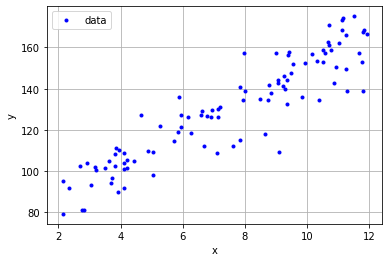

In [37]:
X, y = gen_data_reg(n_samples=100, random_state=27)
X_val, y_val = gen_data_reg(n_samples=10000, random_state=1)
print(X.shape, y.shape)
plot_data(X, y)

In [39]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

@interact(max_depth=(1, 5), mean=True)
def _(max_depth=1, mean=None):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X, y)
    print(f'Depth: {model.get_depth()}')
    print(f'Number of leaves: {model.get_n_leaves()}')
    print(f'Train MSE: {mean_squared_error(y, model.predict(X)):g}')
    if mean:
        plt.axhline(y.mean(), c='g', label='mean')
    plot_data(X, y, model)
    plt.show()
    plt.figure(figsize=(14, 1+model.get_depth()))
    plot_tree(model, feature_names=['x'], filled=True, rounded=True);

interactive(children=(IntSlider(value=1, description='max_depth', max=5, min=1), Checkbox(value=True, descript…

In [5]:
y.mean(), y.var()

(129.91290855197673, 619.1762684843089)

Em cada nó temos:

$\text{MSE}_\text{node} = \displaystyle\frac{1}{m_\text{node}} \sum_{i \in \text{node}} (y^{(i)} - v_\text{node})^2$

com valor de predição ótimo dado por:

$v_\text{node} = \displaystyle\frac{1}{m_\text{node}} \sum_{i \in \text{node}} y^{(i)}$

O limiar $t$ é escolhido de forma a minimizar:

$J(t) = \displaystyle\frac{m_\text{left}}{m} \text{MSE}_\text{left} + \frac{m_\text{right}}{m} \text{MSE}_\text{right}$

onde $\text{left} = \{i: x^{(i)} \leq t\}$ $\;$ e $\;$ $\text{right} = \{i: x^{(i)} > t\}$

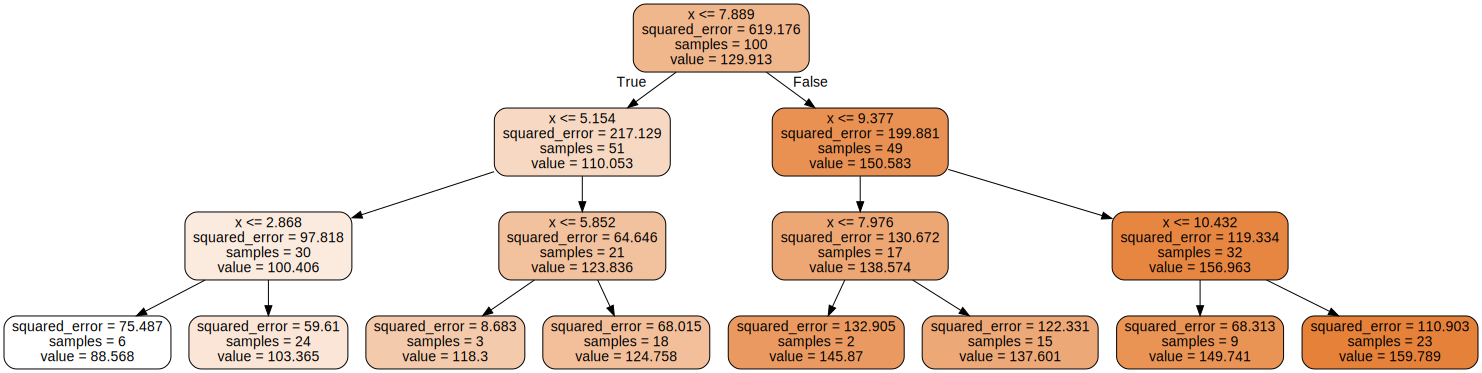

In [40]:
# !conda install python-graphviz
from graphviz import Source
from sklearn.tree import export_graphviz
model = DecisionTreeRegressor(max_depth=3).fit(X, y)
Source(export_graphviz(model, feature_names=['x'], filled=True, rounded=True))
#Source(export_graphviz(model, feature_names=['x'], filled=True, rounded=True)).render(filename='model', format='png') # save to png

### Controlando overfitting

Depth: 15
Number of leaves: 100
Train MSE: 0


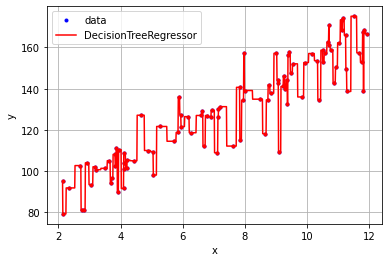

In [42]:
model = DecisionTreeRegressor()
model.fit(X, y)
print(f'Depth: {model.get_depth()}')
print(f'Number of leaves: {model.get_n_leaves()}')
print(f'Train MSE: {mean_squared_error(y, model.predict(X)):g}')
plot_data(X, y, model)

In [43]:
@interact(show_tree=False, max_depth=(1, 20), min_s_split=(2,52), min_s_leaf=(1, 20), max_features=(1, 1), max_leaf_n=(2, 120), 
          min_imp_dec=FloatSlider(value=0, min=0, max=5, step=0.1, readout_format='.3f'), 
          ccp_alpha=FloatSlider(value=0, min=0, max=5, step=0.1, readout_format='.3f'))
def _(show_tree, max_depth=20, min_s_split=2, min_s_leaf=1, max_features=1, max_leaf_n=120, min_imp_dec=0, ccp_alpha=0):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_s_split, min_samples_leaf=min_s_leaf, max_features=max_features,
                                  max_leaf_nodes=max_leaf_n, min_impurity_decrease=min_imp_dec, ccp_alpha=ccp_alpha, random_state=0)
    model.fit(X, y)
    print(f'Depth: {model.get_depth()}')
    print(f'Number of leaves: {model.get_n_leaves()}')
    print(f'Train MSE: {mean_squared_error(y, model.predict(X)):g}')
    print(f'  Val MSE: {mean_squared_error(y_val, model.predict(X_val)):g}')
    plot_data(X, y, model)
    if show_tree:
        plt.show()
        plt.figure(figsize=(14, 1+model.get_depth()))
        plot_tree(model, feature_names=['x'], filled=True, rounded=True);

interactive(children=(Checkbox(value=False, description='show_tree'), IntSlider(value=20, description='max_dep…

Train MSE: 140.863


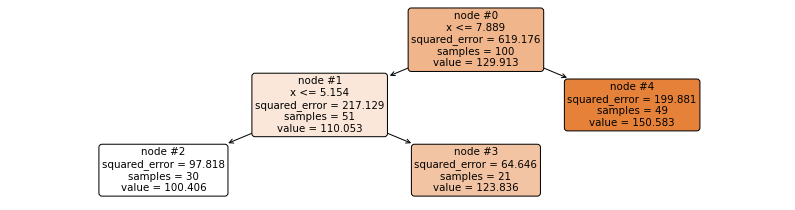

In [46]:
model = DecisionTreeRegressor(min_impurity_decrease=38, random_state=0)
model.fit(X, y)
print(f'Train MSE: {mean_squared_error(y, model.predict(X)):g}')
plt.figure(figsize=(14, 1.2*(1+model.get_depth())))
plot_tree(model, feature_names=['x'], node_ids=True, filled=True, rounded=True);

In [10]:
weighted_mse = model.tree_.impurity * (model.tree_.n_node_samples/model.tree_.n_node_samples[0])

In [11]:
weighted_mse[[2, 3, 5, 6]].sum()

103.32221915598855

In [12]:
weighted_mse[[2, 3, 4]].sum()

140.8630372473414

In [45]:
node = 4
children = [model.tree_.children_left[node], model.tree_.children_right[node]]
impurity_decrease = weighted_mse[node] - weighted_mse[children].sum()
print(f'          MSE of node #{node} : {weighted_mse[node]}')
print(f'MSE of children ({children}) : {weighted_mse[children].sum()}')
print(f'MSE reduction from split : {impurity_decrease}')

          MSE of node #4 : 97.94180931880587
MSE of children ([5, 6]) : 60.40099122745302
MSE reduction from split : 37.54081809135285


Em uma árvore sem nenhuma restrição, overfitting ocorre mesmo com um número enorme de amostras de treinamento:

In [50]:
X, y = gen_data_reg(n_samples=10000, random_state=27)
model = DecisionTreeRegressor()
model.fit(X, y)
print(f'Depth: {model.get_depth()}')
print(f'Number of leaves: {model.get_n_leaves()}')
print(f'MSE: {mean_squared_error(y, model.predict(X)):g}')

Depth: 48
Number of leaves: 9998
MSE: 0.0188374


In [51]:
print(len(np.unique(X)))
print(len(np.unique(X.astype(np.float32))))

10000
9998


In [52]:
y_pred = model.predict(X)
idx = np.where(y != y_pred)[0]
for i in idx:
    print(f'i = {i}, X[i] = {X[i][0]:>8f}, y[i] = {y[i]:>6.2f}, y_pred[i] = {y_pred[i]:>6.2f}')

i = 2453, X[i] = 9.789801, y[i] = 155.20, y_pred[i] = 158.05
i = 4897, X[i] = 4.861494, y[i] = 112.78, y_pred[i] = 103.50
i = 7588, X[i] = 4.861494, y[i] =  94.23, y_pred[i] = 103.50
i = 9908, X[i] = 9.789801, y[i] = 160.91, y_pred[i] = 158.05


In [53]:
@interact(min_s_leaf=(1, 200))
def _(min_s_leaf=0):
    model = DecisionTreeRegressor(min_samples_leaf=min_s_leaf)
    model.fit(X, y)
    print(f'Depth: {model.get_depth()}')
    print(f'Number of leaves: {model.get_n_leaves()}')
    print(f'Train MSE: {mean_squared_error(y, model.predict(X)):g}')
    print(f'  Val MSE: {mean_squared_error(y_val, model.predict(X_val)):g}')
    plot_data(X, y, model)
    plt.show()

interactive(children=(IntSlider(value=1, description='min_s_leaf', max=200, min=1), Output()), _dom_classes=('…

Exemplo em que controlar overfitting não ajuda (muito poucos dados)

In [70]:
def gen_data(n_samples, random_state):
    rng = np.random.RandomState(random_state)
    x = np.linspace(0, 1, n_samples)
    y = 50*np.cos(4*np.pi*x) + 10*rng.standard_normal(size=n_samples)
    X = x.reshape(-1, 1)
    return X, y

(20, 1) (100000, 1) (100000, 1)


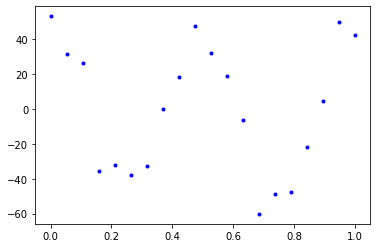

In [71]:
X_train, y_train = gen_data(20, random_state=110)
X_val, y_val = gen_data(100000, random_state=2)
X_test, y_test = gen_data(100000, random_state=5)
print(X_train.shape, X_val.shape, X_test.shape)

plt.plot(X_train, y_train, 'b.');

In [72]:
@interact(show_tree=False, max_depth=(1, 20), min_s_split=(2,52), min_s_leaf=(1, 20), max_features=(1, 1), max_leaf_n=(2, 120), 
          min_imp_dec=FloatSlider(value=0, min=0, max=5, step=0.1, readout_format='.3f'), 
          ccp_alpha=FloatSlider(value=0, min=0, max=5, step=0.1, readout_format='.3f'))
def _(show_tree, max_depth=20, min_s_split=2, min_s_leaf=1, max_features=1, max_leaf_n=120, min_imp_dec=0, ccp_alpha=0):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_s_split, min_samples_leaf=min_s_leaf, max_features=max_features,
                                  max_leaf_nodes=max_leaf_n, min_impurity_decrease=min_imp_dec, ccp_alpha=ccp_alpha, random_state=0)
    model.fit(X_train, y_train)
    print(f'Depth: {model.get_depth()}')
    print(f'Number of leaves: {model.get_n_leaves()}')
    print(f'Train MSE: {mean_squared_error(y_train, model.predict(X_train)):g}')
    print(f'  Val MSE: {mean_squared_error(y_val, model.predict(X_val)):g}')
    plot_data(X_train, y_train, model)
    if show_tree:
        plt.show()
        plt.figure(figsize=(14, 1+model.get_depth()))
        plot_tree(model, feature_names=['x'], filled=True, rounded=True);

interactive(children=(Checkbox(value=False, description='show_tree'), IntSlider(value=20, description='max_dep…

## Classificação

In [57]:
from sklearn.tree import DecisionTreeClassifier

### Conjunto Iris

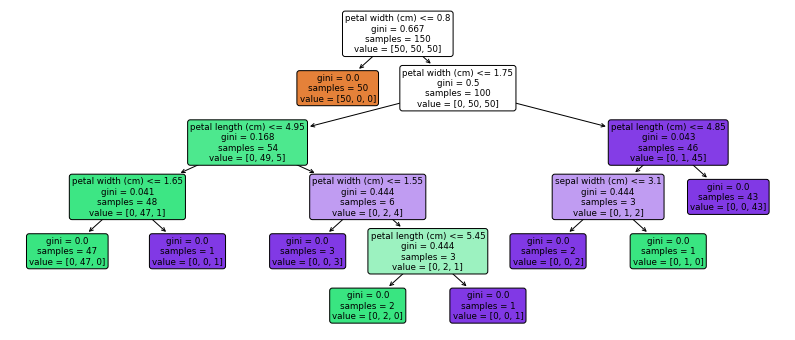

In [58]:
from sklearn.datasets import load_iris
iris = load_iris()
model = DecisionTreeClassifier(random_state=0)
model.fit(iris['data'], iris['target'])
plt.figure(figsize=(14, 1+model.get_depth()))
plot_tree(model, feature_names=iris['feature_names'], filled=True, rounded=True);

In [59]:
pd.Series(model.feature_importances_, index=iris['feature_names']).sort_values(ascending=False)

petal width (cm)     0.922611
petal length (cm)    0.064056
sepal width (cm)     0.013333
sepal length (cm)    0.000000
dtype: float64

In [60]:
cols = [2, 3]
features = list(np.array(iris['feature_names'])[cols])
features

['petal length (cm)', 'petal width (cm)']

In [61]:
X_train, y_train = iris['data'][:, cols], iris['target']

In [62]:
@interact(show_tree=True, max_depth=(1, 20), min_s_split=(2,52), min_s_leaf=(1, 20), max_features=(1, 2), max_leaf_n=(2, 50), 
          min_imp_dec=FloatSlider(value=0, min=1e-4, max=1e-2, step=1e-4, readout_format='.4f'), 
          ccp_alpha=FloatSlider(value=0, min=1e-4, max=1.5e-2, step=1e-4, readout_format='.4f')) 
def _(show_tree, max_depth=20, min_s_split=2, min_s_leaf=1, max_features=2, max_leaf_n=200, min_imp_dec=0, ccp_alpha=0):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_s_split, min_samples_leaf=min_s_leaf, max_features=max_features,
                                  max_leaf_nodes=max_leaf_n, min_impurity_decrease=min_imp_dec, ccp_alpha=ccp_alpha, random_state=0)
    model.fit(X_train, y_train)
    print(f'Depth: {model.get_depth()}')
    print(f'Number of leaves: {model.get_n_leaves()}')
    print(f'Train accuracy: {model.score(X_train, y_train):.2%}')
    plot_data(X_train, y_train, model, N=300, colors=['rx', 'gd', 'bo'])
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    if show_tree:
        plt.show()
        plt.figure(figsize=(14, 1+model.get_depth()))
        plot_tree(model, feature_names=features, filled=True, rounded=True);

interactive(children=(Checkbox(value=True, description='show_tree'), IntSlider(value=20, description='max_dept…

### Conjunto Blobs

(400, 2) (400,)


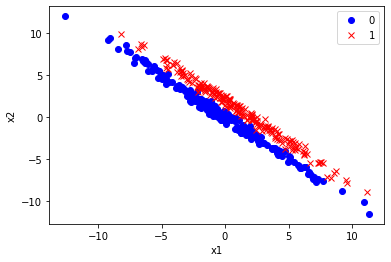

In [63]:
X, y = make_blobs(n_samples=400, n_features=2, centers=[[0,0],[0,1]], cluster_std=0.2, random_state=7)
X_val, y_val = make_blobs(n_samples=400, n_features=2, centers=[[0,0],[0,1]], cluster_std=0.2, random_state=1)
X     = X     @ np.array([[20, -20], [1, 1]])
X_val = X_val @ np.array([[20, -20], [1, 1]])
plot_data(X, y)
print(X.shape, y.shape)

In [64]:
model = LogisticRegression(penalty='none').fit(X, y)
print(f'Train accuracy (Logistic Regression): {model.score(X, y):.2%}')
print(f'  Val accuracy (Logistic Regression): {model.score(X_val, y_val):.2%}')

Train accuracy (Logistic Regression): 99.50%
  Val accuracy (Logistic Regression): 99.50%


In [65]:
@interact(show_tree=False, max_depth=(1, 20), min_s_split=(2,52), min_s_leaf=(1, 20), max_features=(1, 2), max_leaf_n=(2, 50), 
          min_imp_dec=FloatSlider(value=0, min=0, max=0.05, step=0.001, readout_format='.3f'), 
          ccp_alpha=FloatSlider(value=0, min=0, max=0.05, step=0.001, readout_format='.3f'))
def _(show_tree, max_depth=20, min_s_split=2, min_s_leaf=1, max_features=2, max_leaf_n=120, min_imp_dec=0, ccp_alpha=0):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_s_split, min_samples_leaf=min_s_leaf, max_features=max_features,
                                  max_leaf_nodes=max_leaf_n, min_impurity_decrease=min_imp_dec, ccp_alpha=ccp_alpha, random_state=0)
    model.fit(X, y)
    print(f'Depth: {model.get_depth()}')
    print(f'Number of leaves: {model.get_n_leaves()}')
    print(f'Train accuracy: {model.score(X, y):.2%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
    plot_data(X, y, model)
    if show_tree:
        plt.show()
        plt.figure(figsize=(14, 1+model.get_depth()))
        plot_tree(model, feature_names=['x1', 'x2'], filled=True, rounded=True);

interactive(children=(Checkbox(value=False, description='show_tree'), IntSlider(value=20, description='max_dep…

### Conjunto Moons

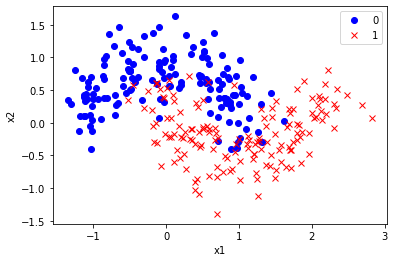

In [66]:
X_train, y_train = make_moons(n_samples=300, noise=0.3, random_state=7)
X_val,   y_val   = make_moons(n_samples=10000, noise=0.3, random_state=1)
X_test,  y_test  = make_moons(n_samples=10000, noise=0.3, random_state=2)
plot_data(X_train, y_train)

Train accuracy (SVC): 89.33%
  Val accuracy (SVC): 90.21%


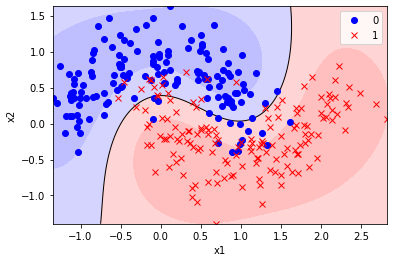

In [67]:
from sklearn.svm import SVC
model = SVC().fit(X_train, y_train)
print(f'Train accuracy ({type(model).__name__}): {model.score(X_train, y_train):.2%}')
print(f'  Val accuracy ({type(model).__name__}): {model.score(X_val, y_val):.2%}')
plot_data(X_train, y_train, model, support=False)

In [68]:
@interact(show_tree=False, max_depth=(1, 20), min_s_split=(2,52), min_s_leaf=(1, 20), max_features=(1, 2), max_leaf_n=(2, 50), 
          min_imp_dec=FloatSlider(value=0, min=1e-4, max=1e-2, step=1e-4, readout_format='.4f'), 
          ccp_alpha=FloatSlider(value=0, min=1e-4, max=1.5e-2, step=1e-4, readout_format='.4f')) 
def _(show_tree, max_depth=20, min_s_split=2, min_s_leaf=1, max_features=2, max_leaf_n=200, min_imp_dec=0, ccp_alpha=0):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_s_split, min_samples_leaf=min_s_leaf, max_features=max_features,
                                  max_leaf_nodes=max_leaf_n, min_impurity_decrease=min_imp_dec, ccp_alpha=ccp_alpha, random_state=0)
    model.fit(X_train, y_train)
    print(f'Depth: {model.get_depth()}')
    print(f'Number of leaves: {model.get_n_leaves()}')
    print(f'Train accuracy: {model.score(X_train, y_train):.2%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
    plot_data(X_train, y_train, model, N=300, reverse_colors=True)
    if show_tree:
        plt.show()
        plt.figure(figsize=(14, 1+model.get_depth()))
        plot_tree(model, feature_names=['x1', 'x2'], filled=True, rounded=True);

interactive(children=(Checkbox(value=False, description='show_tree'), IntSlider(value=20, description='max_dep…

In [ ]:
#ccp 0.78